Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

# ПОДГОТОВКА ДАННЫХ

In [2]:
url = '/Users/mac/Desktop/Python_for_Data_Science/Courswork/train.csv'
data = pd.read_csv(url)

In [3]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


# - исправим во всей базе явные "опечатки" 

проверим "опечатки" и выбросы по следующим признакам:
1. HouseYear - исправили ошибки в написании года
2. Rooms - проверка ошибок в определении кол-ва комнат через среднюю площадь комнаты (Через Square)
3. Square - есть наблюдения с перепутанными значениями Square и LifeSquare(общая площадь не может быть меньше жилой) (решено), есть описка со значениями меньше 10м2 - ошибка с запятой(исправил)
4. LifeSquare - в одном случае ошибка с запятой, 
5. HouseFloor - ограничили высоту 48 этажами(самый восокий жилой дом в москве)
6. KitchenSquare - этот признак и LifeSquare используем для корректировки Square, так пологаю что Square больше связано с ценой нежели эти два признака
9. Social_2
10. Healthcare_1
11. Shops_1
12. Price

! есть сомнения в правильности менять местами Square и LifeSquare, потому что возможна ошибка в запятой LifeSquare и она поэтому перенесется - частично я это устранил после того как поменял местами -но если в последствии не будет хорошего результата на валидационной базе - пересмотрю это момент 

In [5]:
data.loc[data['HouseYear']>2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [6]:
data.loc[data['HouseYear']==20052011,'HouseYear']=2008
data.loc[data['HouseYear']==4968,'HouseYear']=1968

In [7]:
data.loc[data['HouseFloor']>48, 'HouseFloor']=data['Floor']

data.loc[data['Square']<=data['KitchenSquare'],'KitchenSquare']=data['Square']-data['LifeSquare']

In [8]:
data.loc[data['Rooms']<1, 'Rooms']=1

In [9]:
for i in range(data.shape[0]):
    if data['Square'].iloc[i] < data['LifeSquare'].iloc[i]:
        Life_sq = data['Square'].iloc[i]
        data['Square'].iloc[i] = data['LifeSquare'].iloc[i]
        data['LifeSquare'].iloc[i] = Life_sq

In [10]:
Squer_per_rooms=data.loc[:,['Id', 'Square','Rooms']]
Squer_per_rooms.insert(3,'Squer_per_rooms',(data['Square']/data['Rooms']))
Squer_per_rooms.groupby(['Rooms']).mean()

,Id,Square,Squer_per_rooms
Rooms,,,
1.0,8400.760571,41.550415,41.550415
2.0,8399.308763,56.924668,28.462334
3.0,8351.163758,80.489473,26.829824
4.0,8311.353333,98.453655,24.613414
5.0,5438.611111,122.614941,24.522988
6.0,14003.000000,59.414334,9.902389
10.0,10396.000000,59.964120,5.996412
19.0,8491.000000,42.006046,2.210845


In [11]:
data.loc[data['Rooms']>5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [12]:
data.loc[data['Rooms']>5, 'Rooms']=2

In [13]:
Squer_per_rooms=data.loc[:,['Id', 'Square','Rooms','Price']]
Squer_per_rooms.insert(3,'Squer_per_rooms',(data['Square']/data['Rooms']))
Squer_per_rooms.insert(4,'Price_per_Squer',(data['Price']/data['Square']))
Squer_per_rooms.insert(5,'small_and_normal', 0)
for i in range(Squer_per_rooms.shape[0]):
    if Squer_per_rooms['Square'].iloc[i]<10:
        Squer_per_rooms['small_and_normal'].iloc[i]=1
        
Squer_per_rooms.loc[Squer_per_rooms['small_and_normal']==0].groupby(['Rooms']).mean()

,Id,Square,Squer_per_rooms,Price_per_Squer,small_and_normal,Price
Rooms,,,,,,
1.0,8397.467206,41.630899,41.630899,3926.130646,0.0,159662.167423
2.0,8401.803296,56.923033,28.461516,3882.967436,0.0,215239.981996
3.0,8352.885855,80.522991,26.840997,3809.543567,0.0,289395.240382
4.0,8311.353333,98.453655,24.613414,3996.268023,0.0,383251.100956
5.0,5438.611111,122.614941,24.522988,3645.790620,0.0,410431.605679


In [14]:
Squer_per_rooms.loc[Squer_per_rooms['small_and_normal']==1].groupby(['Rooms']).mean()

,Id,Square,Squer_per_rooms,Price_per_Squer,small_and_normal,Price
Rooms,,,,,,
1.0,9926,4.276116,4.276116,71807.638656,1,287796.686095
3.0,4504,5.610772,1.870257,28762.363095,1,161379.067034


In [15]:
(data.loc[data['Rooms']==3]).loc[data['Square']<10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4900,4504,27,3.0,5.610772,4.390331,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034


In [16]:
data.loc[data['Id']==4504,'Square']=data.loc[data['Id']==4504,'Square']*10

In [17]:
data.loc[(data['Rooms']==1)&(data['Square']<10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,4.604943,2.596351,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3413,9487,5,1.0,5.549458,5.129222,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6392,14786,1,1.0,4.525736,1.136859,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8283,15744,34,1.0,2.642219,1.988943,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
9294,6782,45,1.0,5.257278,2.954309,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
9613,7657,38,1.0,4.618547,4.502784,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083


In [18]:
data.loc[(data['Rooms']==1)&(data['Square']<10),'Square']=data.loc[(data['Rooms']==1)&(data['Square']<10),'Square']*10

In [19]:
data.loc[(data['Square']>200)&(data['Rooms']<3)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,263.542020,48.449873,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
1981,7917,27,1.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,410.639749,409.425181,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [20]:
LifeSquare_14990 = data.loc[(data['Id']==14990),'Square']/10
data.loc[(data['Id']==14990),'Square']=data.loc[(data['Id']==14990),'LifeSquare']
data.loc[(data['Id']==14990),'LifeSquare']=LifeSquare_14990

In [21]:
data.loc[(data['Id']==14990)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,48.449873,26.354202,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857


In [22]:
data.loc[(data['Id']==28),'Square']=data.loc[(data['Id']==28),'Square']/10
data.loc[(data['Id']==28),'LifeSquare']=data.loc[(data['Id']==28),'Square']

In [23]:
data.loc[(data['Id']==28)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,60.470597,60.470597,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538


In [24]:
data.loc[(data['Id']==2307),'Square']=data.loc[(data['Id']==2307),'Square']/10
data.loc[(data['Id']==2307),'LifeSquare']=data.loc[(data['Id']==2307),'LifeSquare']/10

In [25]:
data.loc[(data['Id']==2307)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4690,2307,102,1.0,41.063975,40.942518,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.43083


In [26]:
data.loc[(data['Id']==11602),'Square']=data.loc[(data['Id']==11602),'Square']/10
data.loc[(data['Id']==11602),'LifeSquare']=data.loc[(data['Id']==11602),'LifeSquare']/10

In [27]:
data.loc[(data['Id']==11602)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6977,11602,30,2.0,64.106519,63.816319,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [28]:
data.loc[(data['Square']>200)&(data['Rooms']>2)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4328,16550,27,3.0,7480.592129,81.694417,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
8437,15886,85,3.0,461.463614,78.059331,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
9910,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


In [29]:
LifeSquare_16550 = data.loc[(data['Id']==16550),'Square']/100
data.loc[(data['Id']==16550),'Square']=data.loc[(data['Id']==16550),'LifeSquare']
data.loc[(data['Id']==16550),'LifeSquare']=LifeSquare_16550

In [30]:
data.loc[(data['Id']==16550)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,74.805921,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366


In [31]:
LifeSquare_15886 = data.loc[(data['Id']==15886),'Square']/10
data.loc[(data['Id']==15886),'Square']=data.loc[(data['Id']==15886),'LifeSquare']
data.loc[(data['Id']==15886),'LifeSquare']=LifeSquare_15886

In [32]:
data.loc[(data['Id']==15886)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8437,15886,85,3.0,78.059331,46.146361,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978


# - работа с частичными данными 

решение вопроса частичного отсутствия данных в наблюдениях: LifeSquare, Healthcare_1.
выявялем зависимости данных по этим признакам от других для моделирования недостояющих данных/принятия решения по этим данным
для LifeSquare проверим соотношения Square LifeSquare KitchenSquare и заодно связь этих пораметров с Price

!!!
Временно, до первых результатов модели, на основании знакомства с данными, откажемся от параметров LifeSquare KitchenSquare, как от параметоров которые несущественно влияют на цены

Поэтому заполним недостающие данные LifeSquare отношением средних Square к LifeSquare

In [38]:
square_lifesquare=(data['Square'].mean()/data['LifeSquare'].mean())
square_lifesquare

1.5674636021358492

In [39]:
data['LifeSquare']=data['LifeSquare'].fillna(data['Square']/square_lifesquare)

In [40]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.887600,56.310505,36.434511,6.273300,8.526700,12.579800,1984.86600,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.811438,19.116896,16.716945,28.560917,5.241148,6.583507,18.41187,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,15.988889,0.370619,0.000000,1.000000,0.000000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.881659,24.477771,1.000000,4.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.633651,33.389233,6.000000,7.000000,13.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.985903,44.940550,9.000000,12.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,275.645284,233.949309,2014.000000,42.000000,48.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


!!!(перепроверить при плохих результатах на валидационной базе)
предположим что Healthcare_1 зависит от DistrictId и Ecology_1
заполним недостающие данные средними данными по DistrictId

In [106]:
healthcare=data.loc[:,['DistrictId', 'Ecology_1','Healthcare_1','Helthcare_2','Price','HouseYear','Square','Ecology_2','Ecology_3']]
healthcare['Healthcare_1']=healthcare['Healthcare_1'].fillna(1)
healthcare.groupby(['Healthcare_1','Ecology_2','Ecology_3']).mean()

,,,DistrictId,Ecology_1,Helthcare_2,Price,HouseYear,Square
Healthcare_1,Ecology_2,Ecology_3,,,,,,
0.0,B,B,23.000000,1.433395e-02,0.000000,431238.467011,2017.000000,78.062848
1.0,B,B,41.983535,9.007748e-02,0.690079,199834.005543,1987.670488,57.205667
30.0,B,B,35.591954,1.064877e-01,2.000000,193556.882319,1989.011494,57.431116
32.0,B,B,47.000000,1.973680e-01,0.000000,204479.948683,2006.583333,57.498301
35.0,B,B,21.000000,3.940942e-01,0.000000,159530.416728,1983.000000,49.739897
46.0,B,B,79.530612,0.000000e+00,1.000000,377541.709239,1973.122449,63.353628
75.0,B,B,139.937500,4.986339e-02,3.000000,286866.006061,1967.812500,53.253511
80.0,B,B,46.885714,2.322051e-01,0.000000,224514.447614,1989.257143,52.181430
100.0,B,B,150.480000,1.747391e-01,0.000000,303756.217128,1963.400000,58.164366


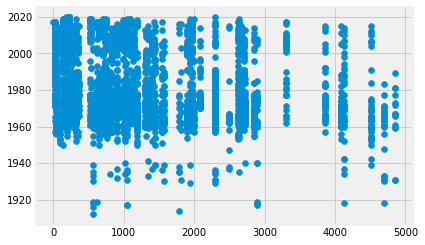

In [58]:
plt.scatter(data['Healthcare_1'],data['HouseYear'])

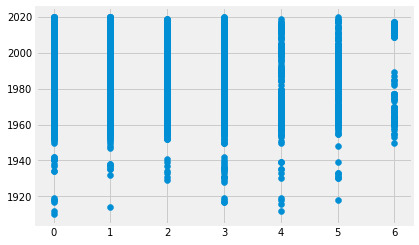

In [70]:
plt.scatter(data['Helthcare_2'],data['HouseYear'])

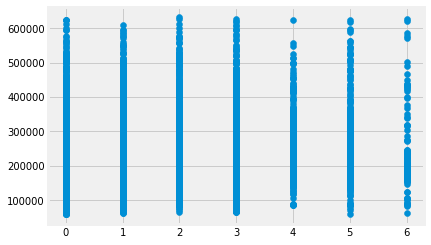

In [63]:
plt.scatter(data['Helthcare_2'],data['Price'])

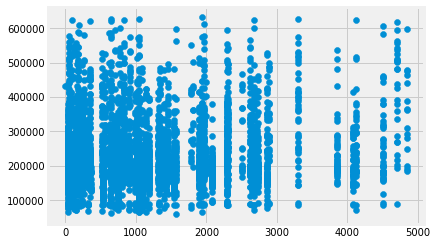

In [65]:
plt.scatter(data['Healthcare_1'],data['Price'])

In [68]:
import seaborn as sns

ValueError: operands could not be broadcast together with shapes (65,) (71,) 

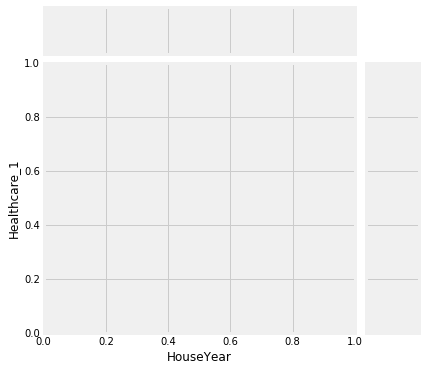

In [71]:
sns.jointplot(data.loc[data['HouseYear']==1997,'HouseYear'],
            data.loc[data['Healthcare_1']==900,'Healthcare_1'])

In [ ]:
healthcare=data.loc[:,['DistrictId', 'Healthcare_1','Helthcare_2','Price']]
Squer_per_rooms.insert(3,'Squer_per_rooms',(data['Square']/data['Rooms']))
Squer_per_rooms.insert(4,'Price_per_Squer',(data['Price']/data['Square']))
Squer_per_rooms.insert(5,'small_and_normal', 0)
for i in range(Squer_per_rooms.shape[0]):
    if Squer_per_rooms['Square'].iloc[i]<10:
        Squer_per_rooms['small_and_normal'].iloc[i]=1
        
Squer_per_rooms.loc[Squer_per_rooms['small_and_normal']==0].groupby(['Rooms']).mean()

In [42]:
data.loc[data['Healthcare_1'].isna()].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,0.0,4798.000000,4798.000000,4798.000000
mean,8386.307211,41.983535,1.851396,57.205667,37.594147,5.856398,8.867653,12.811171,1987.670488,0.090077,20.794498,4737.665069,2.466236,NaN,0.690079,3.309087,199834.005543
std,4864.658955,37.386871,0.813048,19.646660,17.773383,29.563604,5.358387,6.866257,17.684670,0.100627,20.577109,4983.327267,4.289941,NaN,1.180778,4.061253,84900.381989
min,2.000000,1.000000,1.000000,17.414181,0.641822,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,NaN,0.000000,0.000000,59877.592523
25%,4144.250000,23.000000,1.000000,42.163311,25.394285,1.000000,5.000000,9.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,NaN,0.000000,0.000000,143095.449255
50%,8420.500000,27.000000,2.000000,53.736741,34.331596,6.000000,8.000000,14.000000,1977.000000,0.072158,13.000000,3097.000000,1.000000,NaN,0.000000,1.000000,183401.396466
75%,12589.500000,62.000000,2.000000,66.795761,45.893395,9.000000,12.000000,17.000000,2005.000000,0.101872,36.000000,7227.000000,3.000000,NaN,1.000000,5.000000,238193.548403
max,16797.000000,208.000000,5.000000,212.932361,211.231125,2014.000000,37.000000,38.000000,2020.000000,0.521867,74.000000,19083.000000,45.000000,NaN,5.000000,15.000000,622888.825328


# ИССЛЕДОВАНИЕ

что влияет на цену:
площадь
    год 
       комнаты(планировка)
            этаж + высота дома
   
дистрикт
    Экология + хелскеа
        Социальное + Шопс


# - разделим базу на тренировочную и валидационную части

In [107]:
train,valid=train_test_split(data,test_size=0.25, random_state=42)

In [108]:
train.shape, valid.shape

((7500, 20), (2500, 20))

- создание 

In [ ]:
scaler=MinMaxScaler()

In [ ]:
train_scaled=scaler.fit_transform(train.loc[:,['HouseYear','DistrictId']])

выделение параметров, которые будут участвовать в тренировке

In [ ]:
feats=['large_district', 'is_large','cluster_year_0','mean_price_by_dr', 'mean_price_by_rooms',
       'cluster_year_1', 'cluster_year_2','cluster_year_3', 'cluster_year_4']

тренировка метода рандом форест на подготовленных (feats) к тренировке данных в тренировочной базе

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
model=RF(n_estimators=40,max_depth=10,random_state=42)

In [ ]:
model.fit(train.loc[:,feats],train['Price'])

In [ ]:
??? подбор гипер параметров - выбрать лучшие параметры с помощью кип серч для этой модели
как определять лучшие пораметры - через r2??

накатывание через def необходимых для моделирования данных на валидационные данные (добытых при разработки модели на тестовых данных)

In [ ]:
valid=add_distr_info(valid, distr_info1)

In [ ]:
valid=add_mean_price(valid,price_mean_by_distr_rooms,price_mean_by_rooms,price)

In [ ]:
valid=dummies(valid)

Получение данных на обученной модели - предсказания по валидационныым данным по параметрам которые участвуют в моделировании

In [ ]:
y_pred=model.predict(valid.loc[:,feats])

In [ ]:
y_pred

проверка модели на валидационном блоке

In [ ]:
from sklearn.metrics import r2_score as r2

In [ ]:
r2(valid['Price'],y_pred)